# GIS GZ – Übung 9: Thematische Karten <span style="color:red">(Musterlösung)</span>

### Grobziele
* Sie können eine thematische Karte nach wissenschaftlichen Kriterien und kartografischen Prinzipien erstellen. 

### Feinziele
* Sie können die unterschiedlichen Join-Methoden beschreiben und erklären. 
* Sie können tabellarische Daten an Geodaten joinen. 
* Sie können Daten normalisieren. 
* Sie können Datensätze nach unterschiedlichen Methoden klassifizieren und darstellen.
* Sie können die Funktionsweise von drei unterschiedlichen Klassifizierungsmethoden beschreiben. 
* Sie erkennen auf einer Karte, mit welcher Methode der Datensatz klassifiziert wurde. 
* Sie können erklären, weshalb Choroplethenkarten nach bestimmten Regeln gestaltet werden sollten.

### Projekt
* Sie arbeiten an der Lösung Ihrer Fragestellung und wenden die erlernten Techniken aktiv an. 

## Einleitung
In der heutigen Übung betrachten wir die Bevölkerungsentwicklung (Männer + Frauen || Schweizer + Ausländer) in den Gemeinden des Kantons Zürich. Dazu haben wir einen Datensatz, der die totalen Bevölkerungszahlen von 1981 bis und mit 2018 angibt. Angenommen, dass wir von den heutigen Gemeinden ausgehen (also nach allen Gemeindefusionen), berechnet sich die Bevölkerungsdichte dadurch, dass die Azahl an Einwohnern durch die Gemeindefläche geteilt wird. 
Da eine kontinuierliche Farbskala schwer zu interpretieren ist, kann man die Anzahl der angezeigten Farben reduzieren.
Aus diesem Grund wenden wir Klassifizierungen an, die uns die Bevölkerungsdichte in Kategorien aufteilt. Interessant wird es dann, wenn Sie eine Analyse über die Zeit machen, also unterschiedliche Zeitstände miteinander vergleichen. Dazu eignen sich die Methoden der Geoinformatik besonders. 

## Grundregeln
Es sind nicht viele, aber dafür sind sie umso wichtiger:
1. Choroplethenkarten müssen immer mit relativen Werten dargestellt werden! Andersum: In die Flächen kommen immer relative Werte - nie absolute Werte!
2. Faustregel: Wählen Sie 5-8 Kategorien.
3. Vermeiden Sie rot-grüne Farbschemen, da 11% der Männer eine Rot-Grün-Sehschwäche haben. 

## Vorgehen
* Laden Sie mit GeoPandas einen Geodatensatz
* Laden Sie mit Pandas einen Tabellendatensatz und joinen Sie diesen an den Geodatensatz
* Berechnen Sie daraus die Bevölkerungsdichte pro Jahr und speichern Sie diese Information in separaten Spalten
* Plotten Sie einen Zeitstand und eine Klassifizierungsmethode mit GeoPandas
* Erörtern Sie, wie sich die Verteilungen ändern, wenn Sie die Klassifizierungsmethode ändern. 

## Dateien
In dieser Aufgabe erhalten Sie drei Dateien:
* `kanton_zuerich_gemeindegebiet.json` die Geodaten mit den Gemeinden des Kantons Zürich (Achtung: es gibt ein paar Fehler bzw. Inkonsistenzen!)
* `bfs_totale_bevoelkerung_kanton_zuerich_1981_2018.csv` die totale Bevölkerungsanzahl pro Gemeinde anhand der BFS-Nummer des Jahrs 2018 (ohne Unterscheidung zwischen Männern und Frauen bzw. Schweizern und Ausländern)


## Besonderes
* Achtung mit den Encodings beim Importieren von Datensätzen!
* Matplotlib ist eine sehr mächtige Library und kann extrem viel. GeoPandas nutzt Matplotlib, lässt aber nicht in allen Punkten alle Freiheiten zu. Kommen Sie bei Fragen auf die Assistenz zu.

# Datenverarbeitung

In [1]:
%matplotlib inline
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pprint import pprint
#from data.requirements import show_result


# Define important paths
table = os.path.join('data', 'bfs_totale_bevoelkerung_kanton_zuerich_1981_2018.csv')
shapes = os.path.join('data', 'kanton_zuerich_gemeindegebiet.json')

# Read the data into Pandas and GeoPandas
geometries = gpd.read_file(shapes)
table_data = pd.read_table(table, encoding='latin-1', delimiter=';')

# Join the columns of the DataFrame to the GeoDataFrame and extract the area to a new column
df = geometries.merge(table_data, on='BFS_NUMMER')
df['area'] = df.geometry.area

# As duplicate entries for one BFS_NUMMER might exist (due to exclaves), sum up the areas
# for all rows that correspond to the same BFS_NUMMER
all_unique_bfs_nr = list(dict.fromkeys(df.BFS_NUMMER))
for bfs_nr in all_unique_bfs_nr:
    rows = df.loc[df.BFS_NUMMER == bfs_nr]
    number_of_rows = len(rows)
    if number_of_rows > 1:
        total_area = rows.area.sum()
        df.loc[df.BFS_NUMMER == bfs_nr, 'area'] = total_area

# Normalize the entries and store the normalized values to new columns named "normalized_{YEAR}"
year_columns = list(table_data.columns[2:])
for entry in year_columns:
    new_label = 'normalized_{}'.format(entry.rsplit('_')[-1])
    df[new_label] = df[entry] / df['area'] * 1000000


# Klassifikation und Visualisierung
## Aufgabe:
Verwenden Sie die Funktion `show_result(df,column,scheme,axis)` um folgende Karten zu erzeugen:
1. Jeweils eine Karte der Bevölkerungsdichte von 2018 unter Verwendung der drei Klassifikationsmethoden 'equal_interval', 'quantiles' und 'fisher_jenks'.
Notieren Sie sich, was Ihnen auffällt. Welche Methode(n) würden Sie bevorzugen? Warum?

2. Jeweils eine Karte mit der 'fisher_jenks' Methode für die Jahre 1981,2000 und 2018. Welche Gebiete haben sich verändert? Worin können mögliche Gründe dafür liegen?

3. Sehen Sie bei den erstellten Karten Darstellungsprobleme? Wenn ja, wie welche Änderungen müsste man vornehmen?

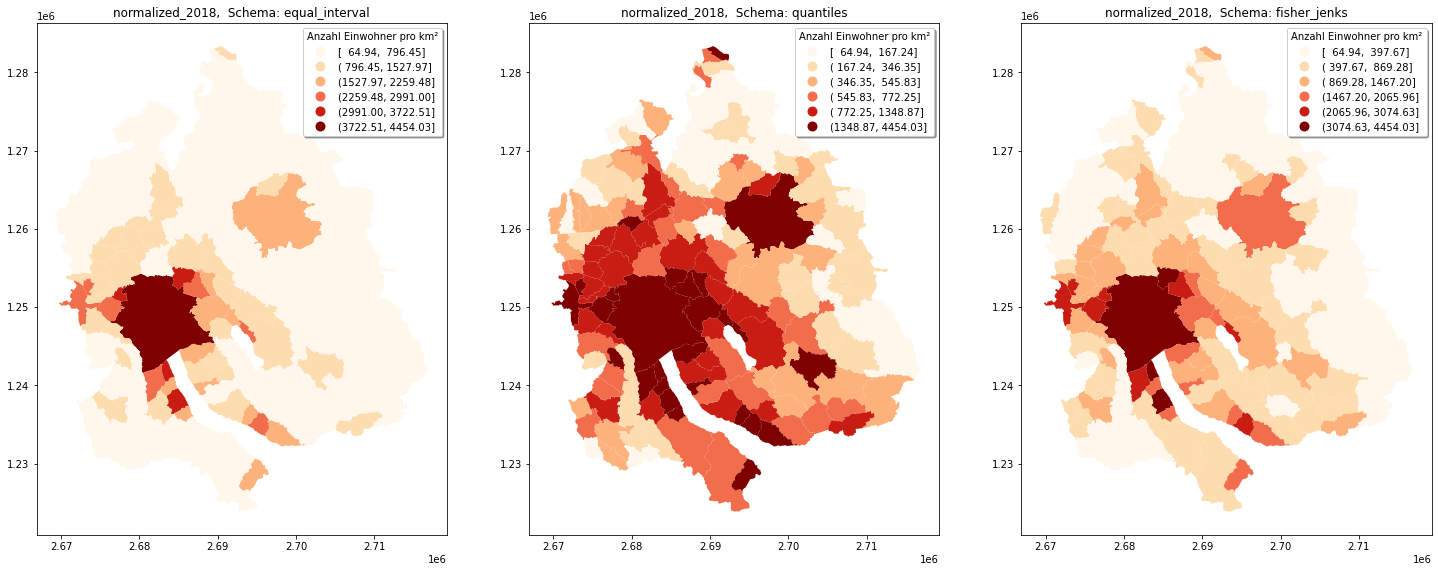

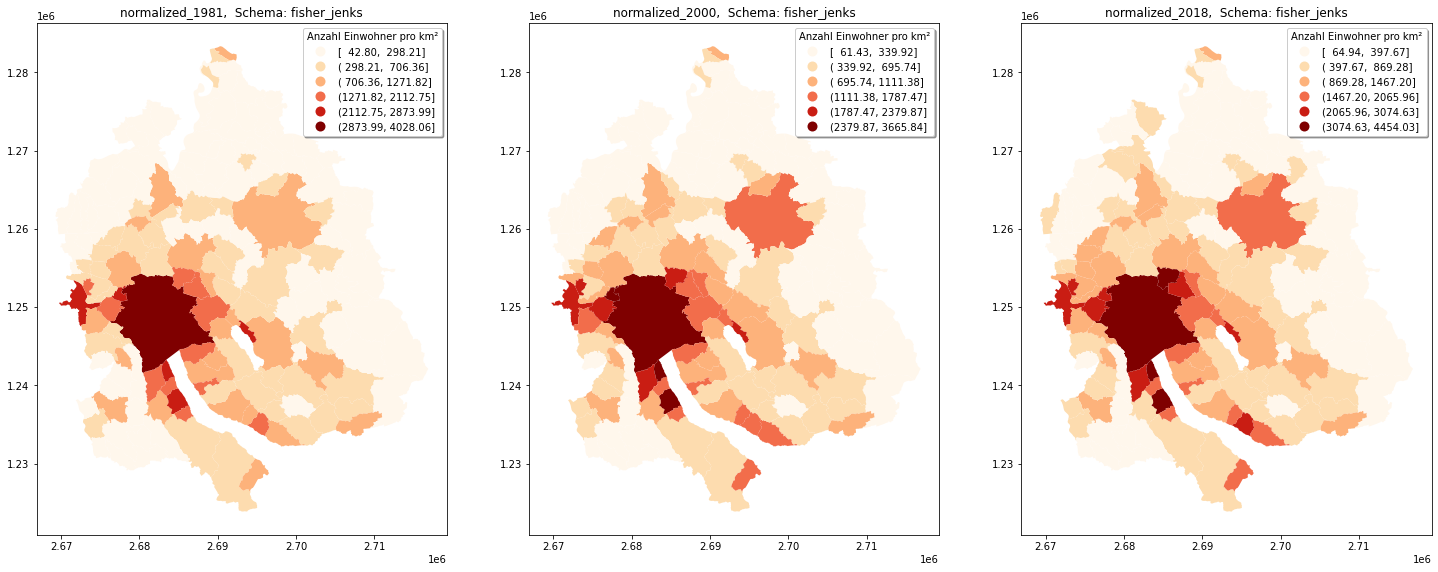

In [3]:
# These are the classification methods you can choose from
classification_methods = ['equal_interval', 'quantiles' , 'fisher_jenks']

def show_result(df,column,scheme,axis):
    """
    Plots the results by using matplotlib
    :param df: The original DataFrame
    :param column: The name of the column that should be displayed
    :param scheme: The classification chosen from a predefined list
    :param axis: The axis where the result should be placed in a subplot
    :return:
    """
    axis.set_title(column +',  Schema: ' + scheme)
    df.plot(column= column, scheme=scheme, k=6, cmap='OrRd', legend=True,legend_kwds={'title': 'Anzahl Einwohner pro km²','loc': 'best','shadow': True}, ax=axis)
    return

fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(25,75),subplot_kw={'aspect': 'equal'})
# TODO: Plot the three different classification methods for the year 2018
show_result(df, 'normalized_2018', 'equal_interval', ax1)
show_result(df, 'normalized_2018', 'quantiles', ax2)
show_result(df, 'normalized_2018', 'fisher_jenks', ax3)


fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(25,75),subplot_kw={'aspect': 'equal'})
# TODO: Plot the three different years 1981, 2000, 2018 with the 'fisher_jenks' method
show_result(df, 'normalized_1981', 'fisher_jenks', ax1)
show_result(df, 'normalized_2000', 'fisher_jenks', ax2)
show_result(df, 'normalized_2018', 'fisher_jenks', ax3)

## Weiterführende Aufgaben (freiwillig)
* Passen Sie die Funktion `show_result` nach Ihren Wünschen an und ändern Sie z.B. das Farbschema oder die Lage der Legende oder die Schattierung. 
* Wie könnte man die zeitlichen Änderungen der Bevölkerungsdichte besser interpretieren?